In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy

In [184]:
def ssvd(X, tol = 1e-3, lambda_us = None, lambda_vs = None, gamma1s = [2], gamma2s = [2], max_iter = 20):
    
    def BIC_v(lambda_v):
        v = abs(v_hat) - lambda_v*w2/2
        df = np.sum(v > 0)
        v[v <= 0] = 0
        v *= np.sign(v_hat)
        return (np.linalg.norm(X - u @ v.T)**2/sigma_sq_hat + np.log(nd)*df, v)
    
    def BIC_u(lambda_u):
        u = abs(u_hat) - lambda_u*w1/2
        df = np.sum(u > 0)
        u[u <= 0] = 0
        u *= np.sign(u_hat)
        return (np.linalg.norm(X - u @ v.T)**2/sigma_sq_hat + np.log(nd)*df, u)
    
    U, S, V = np.linalg.svd(X, full_matrices = False)
    u = U[:,0][:,None]
    v = V[0,:][:,None]
    s = S[0]
    n, d = X.shape
    nd = n*d
    iter_num = 0
    is_lambda_us_given = lambda_us is not None
    is_lambda_vs_given = lambda_vs is not None
    
    while iter_num < max_iter:
        
        # Update v
        v_hat = X.T @ u
        if all(v_hat == 0):
            v_new = v_hat
        else:
            sigma_sq_hat = np.linalg.norm(X - u @ v_hat.T)**2/(nd-d)
            min_BIC_val = float('inf')
            for gamma2 in gamma2s:
                w2 = np.abs(v_hat)**-gamma2
                if not is_lambda_vs_given:
                    lambda_vs = abs(v_hat)*2/w2
                BIC_vals, v_vals = list(zip(*list(map(BIC_v, lambda_vs))))
                if np.min(BIC_vals) < min_BIC_val:
                    min_BIC_val = np.min(BIC_vals)
                    v_new = v_vals[np.argmin(BIC_vals)]
                    if not all(v_new == 0):
                        v_new = v_new/np.linalg.norm(v_new)
        delta_v_norm = np.linalg.norm(v_new - v)
        v = v_new
        
        # Update u
        u_hat = X @ v
        if all(u_hat == 0):
            u_new = u_hat
        else:
            sigma_sq_hat = np.linalg.norm(X - u_hat @ v.T)**2/(nd-d)
            min_BIC_val = float('inf')
            for gamma1 in gamma1s:
                w1 = np.abs(u_hat)**-gamma1
                if not is_lambda_us_given:
                    lambda_us = abs(u_hat)*2/w1
                BIC_vals, u_vals = list(zip(*list(map(BIC_u, lambda_us))))
                if np.min(BIC_vals) < min_BIC_val:
                    min_BIC_val = np.min(BIC_vals)
                    u_new = u_vals[np.argmin(BIC_vals)]
                    if not all (u_new == 0):
                        u_new = u_new/np.linalg.norm(u_new)
        delta_u_norm = np.linalg.norm(u_new - u)
        u = u_new
        
        iter_num += 1
    
        if (delta_v_norm < tol) and (delta_u_norm < tol):
            break
    
    if (delta_v_norm >= tol) or (delta_u_norm >= tol):
        print("Failed to converge in {} iterations. Try increasing tolerance, or increasing the maximum number of iterations.".format(iter_num))
    
    return u, v, s

# Simulation 1 - Rank 1 Approximation

In [32]:
u_tilde = np.concatenate((np.arange(10,2,-1), 2*np.ones(17), np.zeros(75)))[:,None]
u_true = u_tilde/np.linalg.norm(u_tilde)
v_tilde = np.concatenate((np.array([10, -10, 8, -8, 5, -5]), 3*np.ones(5), -3*np.ones(5), np.zeros(34)))[:,None]
v_true = v_tilde/np.linalg.norm(v_tilde)
X_star = 50*u_true*v_true.T
n, d = X_star.shape
np.random.seed(0)
nsims = 100
sims = np.empty((nsims, n, d))
for i in range(nsims):
    sims[i] = X_star + np.random.randn(n, d)

In [33]:
u_true_labels = u_true == 0
v_true_labels = v_true == 0

In [34]:
u_preds, v_preds, s_values = list(zip(*list(map(ssvd, sims))))

In [35]:
print("Misclassification rate for u is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != u_true_labels), u_preds)))*100))
print("Misclassification rate for v is {0:.2f}%".format(np.mean(list(map(lambda x : np.mean((x == 0) != v_true_labels), v_preds)))*100))

Misclassification rate for u is 1.27%
Misclassification rate for v is 0.28%


In [ ]:
# ToDo: Implement and apply other algorithms and compare in Table (Table 1)

# Simulation 2 - Higher Rank Approximation

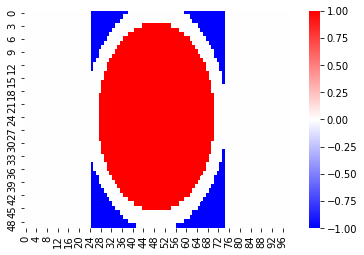

In [42]:
X_star = np.fromfunction(lambda i, j: np.where((25 <= j) & (j <= 74), (24**2 - (i+1-25)**2 - (j+1-50)**2)/100, 0), (50,100)) # like ternary
X_star *= (np.abs(X_star) > 1)
ax = sns.heatmap(X_star, vmin = -1, vmax = 1, cmap = 'bwr')
# ToDo: Make plot better

In [180]:
np.random.seed(0)
nsims = 100
n, d = X_star.shape
sims = np.empty((nsims, n, d))
for i in range(nsims):
    sims[i] = X_star + np.random.randn(n, d)

In [185]:
sims_copy = copy.deepcopy(sims)
layers = 8
estimates = np.empty((layers, nsims, n, d))
for i in range(layers):
    predictions = np.array(list(map(lambda x : x[2] * x[0] @ x[1].T, map(ssvd, sims_copy))))
    estimates[i] = predictions
    sims_copy -= predictions
    
# ToDo: Find out about failed convergence

Failed to converge in 20 iterations. Try increasing tolerance, or increasing the maximum number of iterations.
Failed to converge in 20 iterations. Try increasing tolerance, or increasing the maximum number of iterations.


In [189]:
for i in range(1, layers):
    estimates[i] += estimates[i-1]

In [215]:
ssvd_classification = []
ssvd_fro = []
for i in range(layers):
    # Unsure how to get frobenius distance values... 4000?
    ssvd_fro.append(np.mean(list(map(np.linalg.norm, estimates[i] - X_star))))
    ssvd_classification.append(np.mean(list((map(lambda x : np.mean((x == 0) == X_star_labels), estimates[i])))))

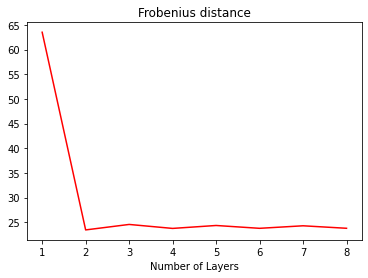

In [222]:
plt.plot(np.arange(1,9), ssvd_fro, label = "SSVD", color = "red");
plt.xlabel("Number of Layers")
plt.title("Frobenius distance");

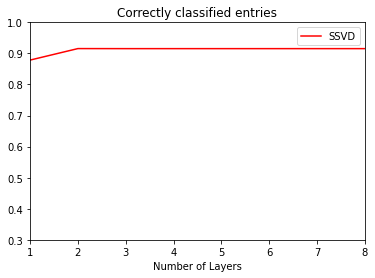

In [221]:
plt.plot(np.arange(1,9), ssvd_classification, label = "SSVD", color = "red")
plt.xlabel("Number of Layers")
plt.ylim([0.3, 1])
plt.xlim([1, 8])
plt.title("Correctly classified entries")
plt.legend();

In [ ]:
# ToDo: Fix algorithm convergence, apply other algorithms, and compare with Figure 5

# Lung Cancer Data

In [7]:
X_lung = np.loadtxt('lungcancerdata.txt', delimiter = ' ').T

In [8]:
u1, v1, s1 = ssvd(X_lung)
X_lung -= s1*(u1 @ v1.T)
u2, v2, s2 = ssvd(X_lung)
X_lung -= s2*(u2 @ v2.T)
u3, v3, s3 = ssvd(X_lung)

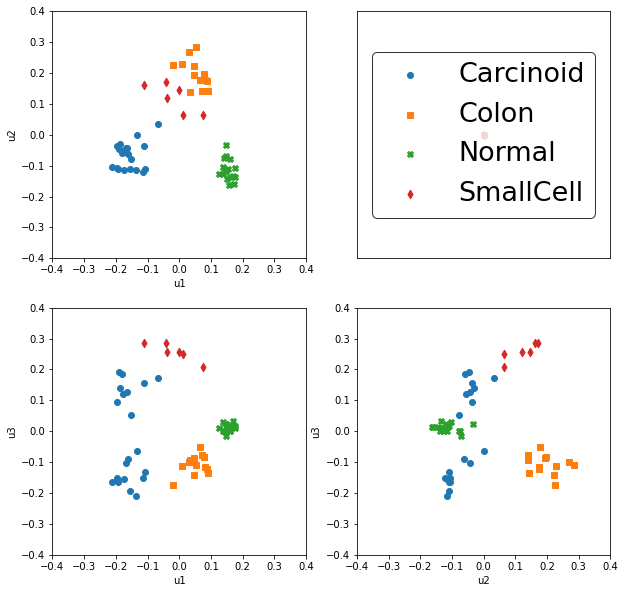

In [9]:
group_indices = [np.arange(20), np.arange(20,33), np.arange(33,50), np.arange(50,56)]
markers = ["o", "s", "X", "d"]
labels = ["Carcinoid", "Colon", "Normal", "SmallCell"]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for row in axs:
    for ax in row:
        ax.set_xlim([-0.4, 0.4])
        ax.set_ylim([-0.4, 0.4])
for i in range(len(group_indices)):
    group = group_indices[i]
    axs[0,0].scatter(u1[group], u2[group], marker = markers[i])
    axs[1,0].scatter(u1[group], u3[group], marker = markers[i])
    axs[1,1].scatter(u2[group], u3[group], marker = markers[i])
    axs[0,1].scatter(0, 0, marker = markers[i], label = labels[i])
axs[0,1].legend(loc = 10, fontsize=27).get_frame().set_edgecolor('black')
axs[0,0].set_xlabel("u1")
axs[1,0].set_xlabel("u1")
axs[1,1].set_xlabel("u2")
axs[0,0].set_ylabel("u2")
axs[1,0].set_ylabel("u3")
axs[1,1].set_ylabel("u3")
axs[0,1].set_yticks(()) 
axs[0,1].set_xticks(());

In [34]:
def get_X_for_plotting(u, v, s):
    group_indices = [np.arange(20), np.arange(20,33), np.arange(33,50), np.arange(50,56)]
    for group in group_indices:
        u[group] = np.sort(u[group], axis = 0)

    v_nonzero = v[np.argsort(np.abs(v), axis = 0)[8000:].flatten()]
    v = np.sort(v_nonzero, axis = 0)
    return s * u @ v.T

In [37]:
X1 = get_X_for_plotting(u1, v1, s1)
X2 = get_X_for_plotting(u2, v2, s2)
X3 = get_X_for_plotting(u3, v3, s3)
max_val = np.max(np.abs(np.c_[X1,X2,X3]))
# rescale for increased contrast due to differing colormap
rescale = 3
X1 /= max_val/rescale
X2 /= max_val/rescale
X3 /= max_val/rescale

In [30]:
def plot_lung(X, title, xticks, ax_given, cbar_ax, yticklabels):
    ax = sns.heatmap(X, vmin = -1, vmax = 1, cmap = 'bwr', ax = ax_given, cbar_ax = cbar_ax)
    ax.hlines([20, 33, 50], *ax.get_xlim(), linestyle=':', color = 'sienna')
    ax.vlines([xticks[0], xticks[1]-8000], *ax.get_xlim(), linestyle=':', color = 'sienna')
    ax.set_xticks((xticks[0], xticks[1]-8000)) 
    ax.set_xticklabels((str(xticks[0]), str(xticks[1])), rotation = 0)
    ax.set_yticks((10, 27, 42, 53)) 
    ax.set_yticklabels(yticklabels) 
    ax.set_title(title)
    ax.set_xlabel("Ordered gene index");

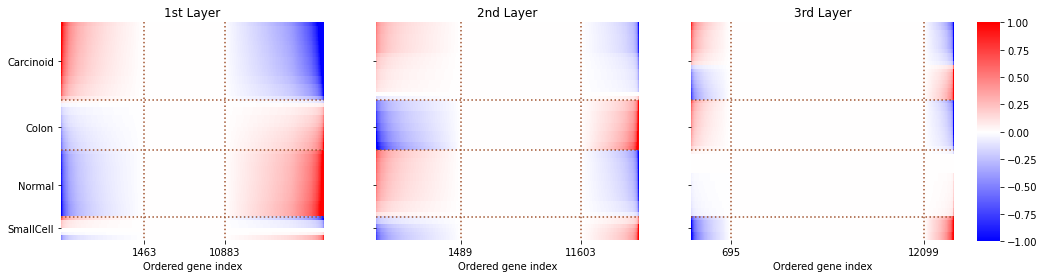

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 4))
cbar_ax = fig.add_axes([.92, .12, .02, 0.76])
plot_lung(X1, "1st Layer", [1463, 10883], ax1, cbar_ax, ("Carcinoid", "Colon", "Normal", "SmallCell"))
plot_lung(X2, "2nd Layer", [1489, 11603], ax2, cbar_ax, ())
plot_lung(X3, "3rd Layer", [695, 12099], ax3, cbar_ax, ())

In [ ]:
# ToDo: Do Figure 3 (probably impossible without access to http://www.unc.edu/~haipeng) and Figure 4. 